In [ ]:
# Cell 1: Core data handling and analysis libraries
import pandas as pd
import numpy as np
import os

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import cv2  # OpenCV for image processing

# Scikit-learn for metrics and data splitting
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow and Keras for building and training neural networks
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model # Import Model for transfer learning
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, GlobalAveragePooling2D # Add GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2 # Import MobileNetV2 for transfer learning

# Ensure consistency for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported and seeds set.")

Libraries imported and seeds set.


In [ ]:
DATA_DIR = '/kaggle/input/coffee-bean-dataset-resized-224-x-224'
df = pd.read_csv(os.path.join(DATA_DIR, 'Coffee Bean.csv'))

# Display the first few rows to verify data loading
print("First 5 rows of the DataFrame:")
print(df.head())

# Get basic information about the dataframe
print("\nDataFrame Info:")
df.info()

# Check for any missing values
print("\nMissing Values:")
print(df.isnull().sum())

First 5 rows of the DataFrame:
   class index                  filepaths labels data set
0            0    train/Dark/dark (1).png   Dark    train
1            0   train/Dark/dark (10).png   Dark    train
2            0  train/Dark/dark (100).png   Dark    train
3            0  train/Dark/dark (101).png   Dark    train
4            0  train/Dark/dark (102).png   Dark    train

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class index  1600 non-null   int64 
 1   filepaths    1600 non-null   object
 2   labels       1600 non-null   object
 3   data set     1600 non-null   object
dtypes: int64(1), object(3)
memory usage: 50.1+ KB

Missing Values:
class index    0
filepaths      0
labels         0
data set       0
dtype: int64


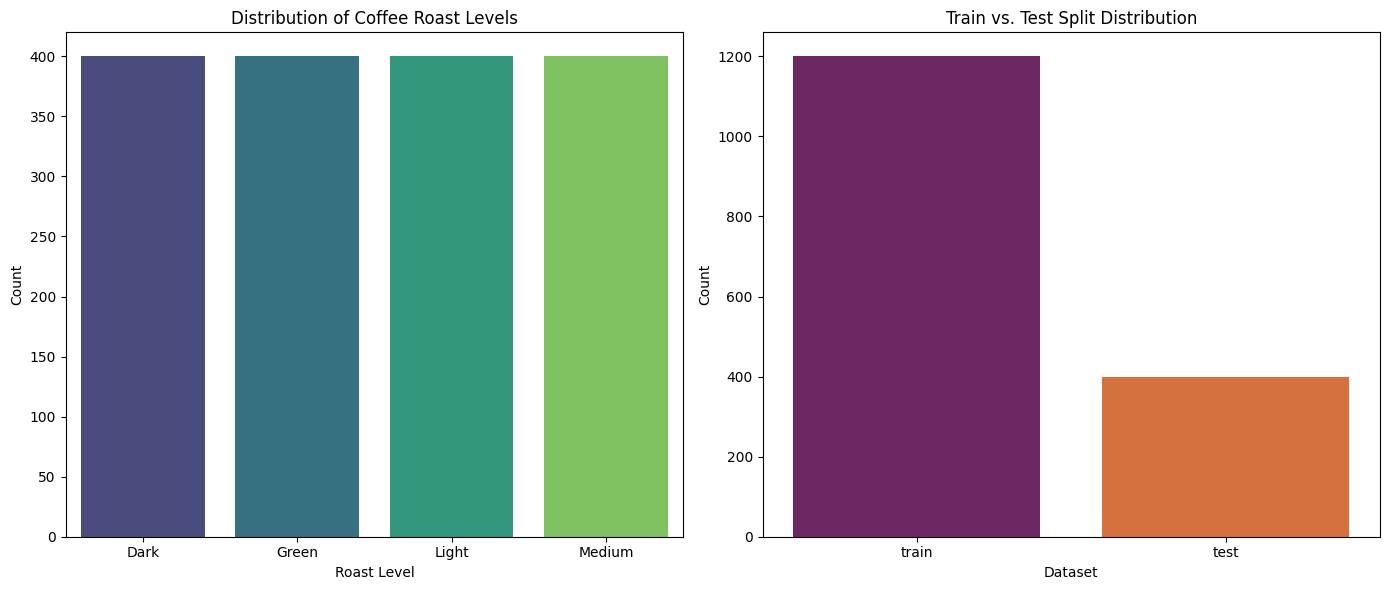

Label Counts:
 labels
Dark      400
Green     400
Light     400
Medium    400
Name: count, dtype: int64

Dataset Split Counts:
 data set
train    1200
test      400
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(14, 6))

# Plot distribution of labels (roast levels)
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='labels', order=df['labels'].value_counts().index, palette='viridis')
plt.title('Distribution of Coffee Roast Levels')
plt.xlabel('Roast Level')
plt.ylabel('Count')

# Plot distribution of train/test split
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='data set', palette='inferno')
plt.title('Train vs. Test Split Distribution')
plt.xlabel('Dataset')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print exact counts for clarity
print("Label Counts:\n", df['labels'].value_counts())
print("\nDataset Split Counts:\n", df['data set'].value_counts())

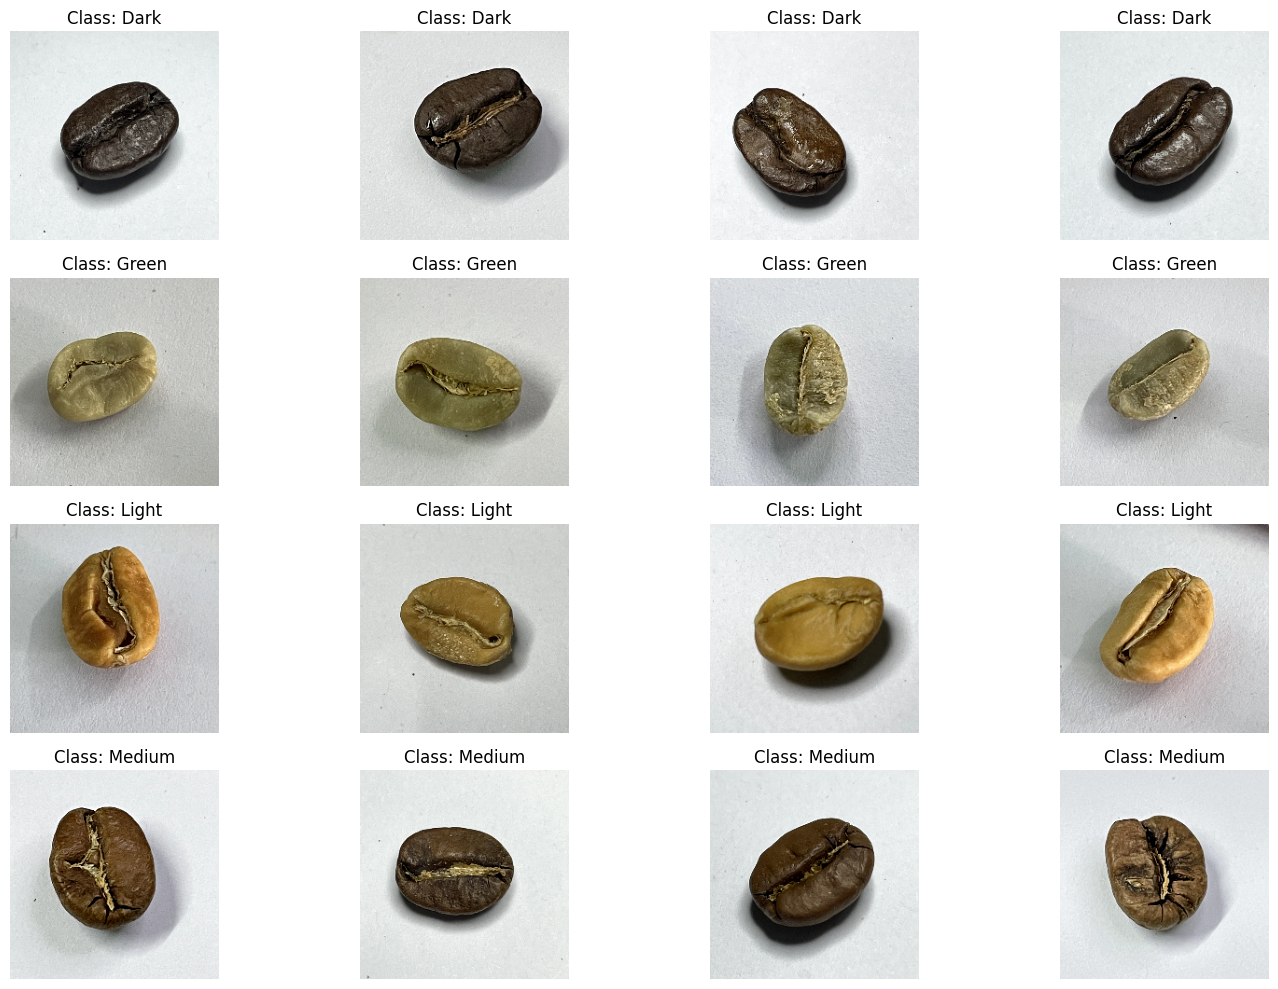

In [ ]:
def show_sample_images(df, num_samples=4):
    plt.figure(figsize=(15, 10))
    # Get unique labels sorted for consistency
    labels = sorted(df['labels'].unique())

    for i, label in enumerate(labels):
        # Get random filepaths for the current label
        sample_df = df[df['labels'] == label].sample(num_samples, random_state=42)
        for j, filepath in enumerate(sample_df['filepaths']):
            # Construct the full image path
            img_path = os.path.join(DATA_DIR, filepath)
            img = cv2.imread(img_path)
            # Convert from BGR (OpenCV default) to RGB for correct display
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(len(labels), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(f'Class: {label}')
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample images from the dataset
show_sample_images(df)

In [ ]:
train_df = df[df['data set'] == 'train'].copy()
test_df = df[df['data set'] == 'test'].copy()

# Define image dimensions and other parameters
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32

# Create a data generator for training with augmentation and a validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to [0, 1]
    rotation_range=20,        # Randomly rotate images
    width_shift_range=0.1,    # Randomly shift images horizontally
    height_shift_range=0.1,   # Randomly shift images vertically
    shear_range=0.1,          # Apply shearing transformations
    zoom_range=0.1,           # Randomly zoom in on images
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode='nearest',      # Fill newly created pixels with the nearest value
    validation_split=0.2      # Reserve 20% of training data for validation
)

# Create a data generator for testing (only rescaling, no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Update filepaths to be absolute for ImageDataGenerator
train_df['filepaths'] = train_df['filepaths'].apply(lambda x: os.path.join(DATA_DIR, x))
test_df['filepaths'] = test_df['filepaths'].apply(lambda x: os.path.join(DATA_DIR, x))

# Create data iterators from the dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training' # Use the first 80% for training
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation' # Use the remaining 20% for validation
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Do not shuffle test data for consistent evaluation
)

Found 960 validated image filenames belonging to 4 classes.
Found 240 validated image filenames belonging to 4 classes.
Found 400 validated image filenames belonging to 4 classes.


In [ ]:
base_model = MobileNetV2(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the layers of the base model so they are not trained
# This keeps the powerful pre-learned features intact
base_model.trainable = False

# Create a new model on top of the pre-trained base
x = base_model.output
# Add a GlobalAveragePooling2D layer to reduce the spatial dimensions
# This is a common practice after convolutional layers in transfer learning
x = GlobalAveragePooling2D()(x)
# Add a dense layer for classification
x = Dense(128, activation='relu')(x)
# Add dropout for regularization to prevent overfitting
x = Dropout(0.5)(x)
# Output layer with 4 units (for 4 classes) and softmax activation for probabilities
predictions = Dense(4, activation='softmax')(x)

# Define the full model
transfer_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
# Using Adam optimizer with a slightly lower learning rate is often beneficial for transfer learning
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Reduced learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
transfer_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Cell 7: Define Callbacks and Train the Model

# Callbacks for efficient training
# EarlyStopping: Stops training if validation loss does not improve for 'patience' epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# ReduceLROnPlateau: Reduces learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the transfer learning model
print("\nStarting model training...")
history_transfer = transfer_model.fit(
    train_generator,
    epochs=50, # Set a sufficiently high number, EarlyStopping will manage the actual epochs
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)
print("Model training finished.")


Starting model training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 719ms/step - accuracy: 0.3031 - loss: 1.8087 - val_accuracy: 0.0000e+00 - val_loss: 3.3010 - learning_rate: 1.0000e-04
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 464ms/step - accuracy: 0.5844 - loss: 0.9875 - val_accuracy: 0.0417 - val_loss: 2.0198 - learning_rate: 1.0000e-04
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 471ms/step - accuracy: 0.7369 - loss: 0.7035 - val_accuracy: 0.1042 - val_loss: 1.8121 - learning_rate: 1.0000e-04
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 462ms/step - accuracy: 0.8239 - loss: 0.5271 - val_accuracy: 0.1208 - val_loss: 1.8172 - learning_rate: 1.0000e-04
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 469ms/step - accuracy: 0.8622 - loss: 0.4215 - val_accuracy: 0.1750 - val_loss: 1.6353 - learning_rate: 1.0000e-04
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 469ms/step - accuracy: 0.9043 - loss: 0.3497 - val_accuracy: 0.2042 - val_loss: 1.4597 - learning_rate: 1.0000e-04
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 460ms/step -


Plotting training history...


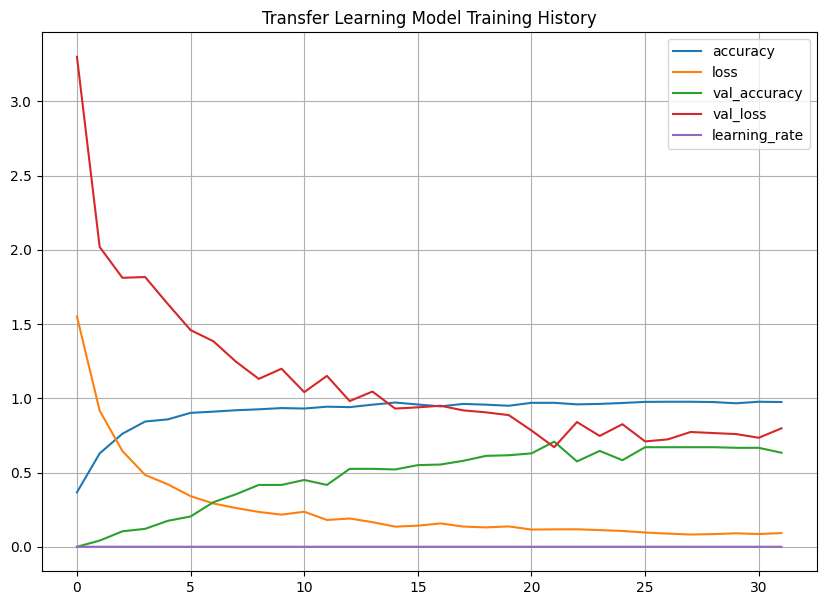

Training history plot displayed.


In [ ]:
print("\nPlotting training history...")
pd.DataFrame(history_transfer.history).plot(figsize=(10, 7))
plt.title("Transfer Learning Model Training History")
plt.grid(True)
plt.show()
print("Training history plot displayed.")


Evaluating model on the test set...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8268 - loss: 0.4082
Transfer Model Test Accuracy: 0.9000
Transfer Model Test Loss: 0.2485

Generating predictions and classification report...
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 356ms/step

Transfer Model Classification Report:

              precision    recall  f1-score   support

        Dark       1.00      0.64      0.78       100
       Green       0.98      1.00      0.99       100
       Light       0.99      0.97      0.98       100
      Medium       0.73      0.99      0.84       100

    accuracy                           0.90       400
   macro avg       0.92      0.90      0.90       400
weighted avg       0.92      0.90      0.90       400



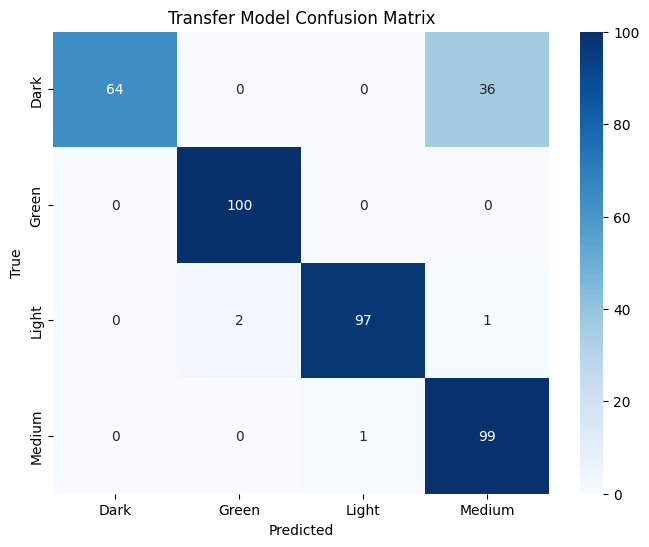

Evaluation complete and plots displayed.


In [ ]:
print("\nEvaluating model on the test set...")
transfer_loss, transfer_accuracy = transfer_model.evaluate(test_generator)
print(f"Transfer Model Test Accuracy: {transfer_accuracy:.4f}")
print(f"Transfer Model Test Loss: {transfer_loss:.4f}")

# Generate predictions for the classification report and confusion matrix
print("\nGenerating predictions and classification report...")
y_pred_transfer = transfer_model.predict(test_generator)
y_pred_classes_transfer = np.argmax(y_pred_transfer, axis=1)

# Get true labels from the test generator
y_true = test_generator.classes
# Get class labels in the order used by the generator
class_labels = list(test_generator.class_indices.keys())

# Print the classification report
print("\nTransfer Model Classification Report:\n")
print(classification_report(y_true, y_pred_classes_transfer, target_names=class_labels))

# Plot the confusion matrix
cm_transfer = confusion_matrix(y_true, y_pred_classes_transfer)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_transfer, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Transfer Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print("Evaluation complete and plots displayed.")
